<a href="https://colab.research.google.com/github/IngenieurSong/KMU_IntelligenceOfVehicles/blob/main/pytorch_lanenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!git clone https://github.com/Lhyejin/LaneNet-PyTorch.git

Cloning into 'LaneNet-PyTorch'...
remote: Enumerating objects: 191, done.
remote: Counting objects: 100% (191/191), done.
remote: Compressing objects: 100% (156/156), done.
remote: Total 191 (delta 55), reused 154 (delta 27), pack-reused 0
Receiving objects: 100% (191/191), 29.32 MiB | 23.22 MiB/s, done.
Resolving deltas: 100% (55/55), done.


In [10]:
%cd LaneNet-PyTorch//
!ls
!pip install -r requirements.txt

/content/LaneNet-PyTorch/LaneNet-PyTorch
dataset  LICENSE	      requirements.txt	Train.ipynb
img	 Notebook-experiment  test.py		TUSIMPLE
Lanenet  README.md	      Train_aug.ipynb	utils


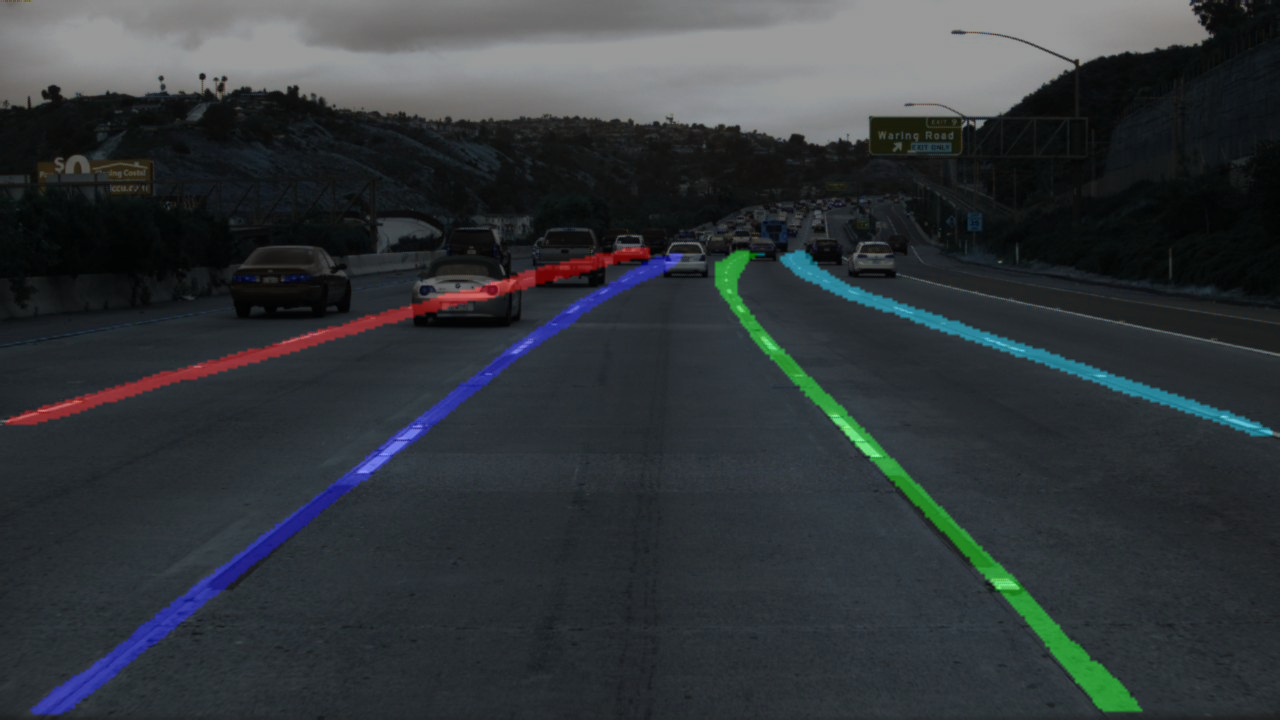

In [11]:
import os.path as ops
import numpy as np
import torch
import cv2
import time
import os
import matplotlib.pylab as plt
import sys
from tqdm import tqdm
import imageio
from dataset.dataset_utils import TUSIMPLE
from Lanenet.model2 import Lanenet
from utils.evaluation import gray_to_rgb_emb, process_instance_embedding
from google.colab.patches import cv2_imshow

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the Model
model_path = './TUSIMPLE/Lanenet_output/lanenet_epoch_39_batch_8.model'
LaneNet_model = Lanenet(2, 4)
LaneNet_model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
LaneNet_model.to(device)

def inference(gt_img_org):
    # BGR 순서
    org_shape = gt_img_org.shape
    gt_image = cv2.resize(gt_img_org, dsize=(512, 256), interpolation=cv2.INTER_LINEAR)
    gt_image = gt_image / 127.5 - 1.0
    gt_image = torch.tensor(gt_image, dtype=torch.float)
    gt_image = np.transpose(gt_image, (2, 0, 1))
    gt_image = gt_image.to(device)
    # lane segmentation 
    binary_final_logits, instance_embedding = LaneNet_model(gt_image.unsqueeze(0))
    binary_final_logits, instance_embedding = binary_final_logits.to('cpu'), instance_embedding.to('cpu') 
    binary_img = torch.argmax(binary_final_logits, dim=1).squeeze().numpy()
    binary_img[0:65,:] = 0

    # lane clustering & segemented frame embedding
    rbg_emb, cluster_result = process_instance_embedding(instance_embedding, binary_img,
                                                          distance=1.5, lane_num=4)

    rbg_emb = cv2.resize(rbg_emb, dsize=(org_shape[1], org_shape[0]), interpolation=cv2.INTER_LINEAR)
    a = 0.6
    frame = a * gt_img_org[..., ::-1] / 255 + rbg_emb * (1 - a)
    frame = np.rint(frame * 255)
    frame = frame.astype(np.uint8)

    return frame


image = cv2.imread('TUSIMPLE/test_clips/1494452927854312215/1.jpg')
cv2_imshow(inference(image))

In [24]:
def video2segemented_video(video_path):
    # TODO: video to frames
    vidcap = cv2.VideoCapture(video_path)
    success, image = vidcap.read()

    cnt = 1
    success = True

    while success:
      success, image = vidcap.read()
      cv2.imwrite("/content/LaneNet-PyTorch/img/imageStore/%d.jpg" %cnt, image)

      cnt += 1
  
    # TODO: extract lane from frame
    filename = "/content/LaneNet-PyTorch/img/imageStore/*"
    img_path = gb.glob(filename)

    for path in img_path:
        img = cv2.imread(path)
        inference(returnImage)

    # TODO: frames to video & store video
    filename = "./imageStore/*"
    img_path = gb.glob(filename)

    videoWriter = cv2.VideoWriter('frame2video.avi', cv2.VideoWriter_fourcc(*'MJPG'), 25, (640, 480))

    for path in img_path:
        img = cv2.imread(path)
        img = cv2.resize(img, (640, 480))
        videoWriter.write(img)

In [25]:
# Test
video_path = "./content/LaneNet-PyTorch/img/solidWhiteRight.mp4" # input your video path
video2segemented_video(video_path)

error: ignored